# 17. Analizando el modelo ganador

## Importamos paquetes necesarios

In [1]:
import pandas as pd
import numpy as np
import pydotplus

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier

from skopt import gp_minimize
from skopt.space import Categorical, Dimension, Integer, Real  # noqa

from IPython.display import Image  

import graphviz_tools as agt
import tree_utils as atu

## Cargamos nuestros dataset

In [31]:
file_cervezas_unicas_resumen_valores_con_clase_training = 'dataset/cervezas_unicas_resumen_valores_con_clase_train.csv'
file_cervezas_unicas_resumen_valores_con_clase_testing = 'dataset/cervezas_unicas_resumen_valores_con_clase_test.csv'

campos = [
    'beer_abv', 
    'review_aroma', 
    'review_appearance', 
    'review_taste', 
    'review_overall', 
    'review_palate', 
    'es_popular'
]

df_training_validacion = pd.read_csv(file_cervezas_unicas_resumen_valores_con_clase_training)
df_info = df_training_validacion.copy()
df_testing = pd.read_csv(file_cervezas_unicas_resumen_valores_con_clase_testing)

df_training_validacion = df_training_validacion.loc[:, campos]
df_testing = df_testing.loc[:, campos]

df_training_validacion.head()

,beer_abv,review_aroma,review_appearance,review_taste,review_overall,review_palate,es_popular
0,6.0,3.564000,3.736000,3.592000,3.776000,3.620000,NO
1,4.5,2.608108,3.351351,2.743243,2.945946,3.054054,NO
2,4.4,3.727273,3.727273,3.545455,3.545455,3.545455,NO
3,7.5,3.750000,3.500000,3.750000,3.750000,4.000000,NO
4,7.8,2.500000,3.500000,3.500000,3.500000,3.500000,NO


In [3]:
random_state = 1
test_size = 0.3

atributos = [
    'beer_abv', 
    #'review_aroma', 
    'review_appearance', 
    'review_taste', 
    #'review_overall', 
    #'review_palate'
]
clase = ['es_popular']

Y_df_training_validacion = df_training_validacion.loc[:, clase]
df_training_validacion = df_training_validacion.loc[:, atributos]

### Tambien abrimos en X e Y el dataset de testing

In [4]:
X_testing = df_testing.loc[:, atributos]
Y_testing = df_testing.loc[:, clase]

### Utilizamos estos parámetros para crear un nuevo modelo

In [5]:
umbral_de_corte = 0.9347742929485793
max_depth = 19
min_samples_split =  0.01340442492243973
max_features =  0.8468150578083835

#criterion='entropy'
criterion='gini'
#criterion='log_loss'

clf = DecisionTreeClassifier(
            criterion = criterion,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            max_features=max_features,
            random_state=1
        )
_ = clf.fit(df_training_validacion, Y_df_training_validacion)


### Probamos los nuevos parámetros en testing

In [6]:
y_testing_pred = clf.predict_proba(X_testing)

df_y_testing_pred_proba = pd.DataFrame(y_testing_pred, columns = ['NO_prob', 'SI_prob'])
y_testing_pred = atu.evaluar_corte(df_y_testing_pred_proba['NO_prob'].values, umbral_de_corte, 'SI', 'NO')

metricas = atu.calcular_metricas(
    y_true = Y_testing['es_popular'].values, 
    y_pred = y_testing_pred, 
    labels=['NO', 'SI']
)

parametros = {
    'max_depth': max_depth,
    'umbral_corte': umbral_de_corte, 
    'min_samples_split': min_samples_split,
    'max_features': max_features
}
    
[metricas, parametros]

[{'true negatives': 10667,
  'true positives': 648,
  'false positives': 3299,
  'false negatives': 90,
  'accuracy': 0.7695,
  'recall': 0.878,
  'precision': 0.1642,
  'specificity': 0.7638,
  'tasa falso positivo': 0.2362,
  'tasa falso negativo': 0.0064,
  'f1': 0.2766,
  'metrica negocio': 2618.1571815718157,
  'metrica optima negocio': 4000.0},
 {'max_depth': 19,
  'umbral_corte': 0.9347742929485793,
  'min_samples_split': 0.01340442492243973,
  'max_features': 0.8468150578083835}]

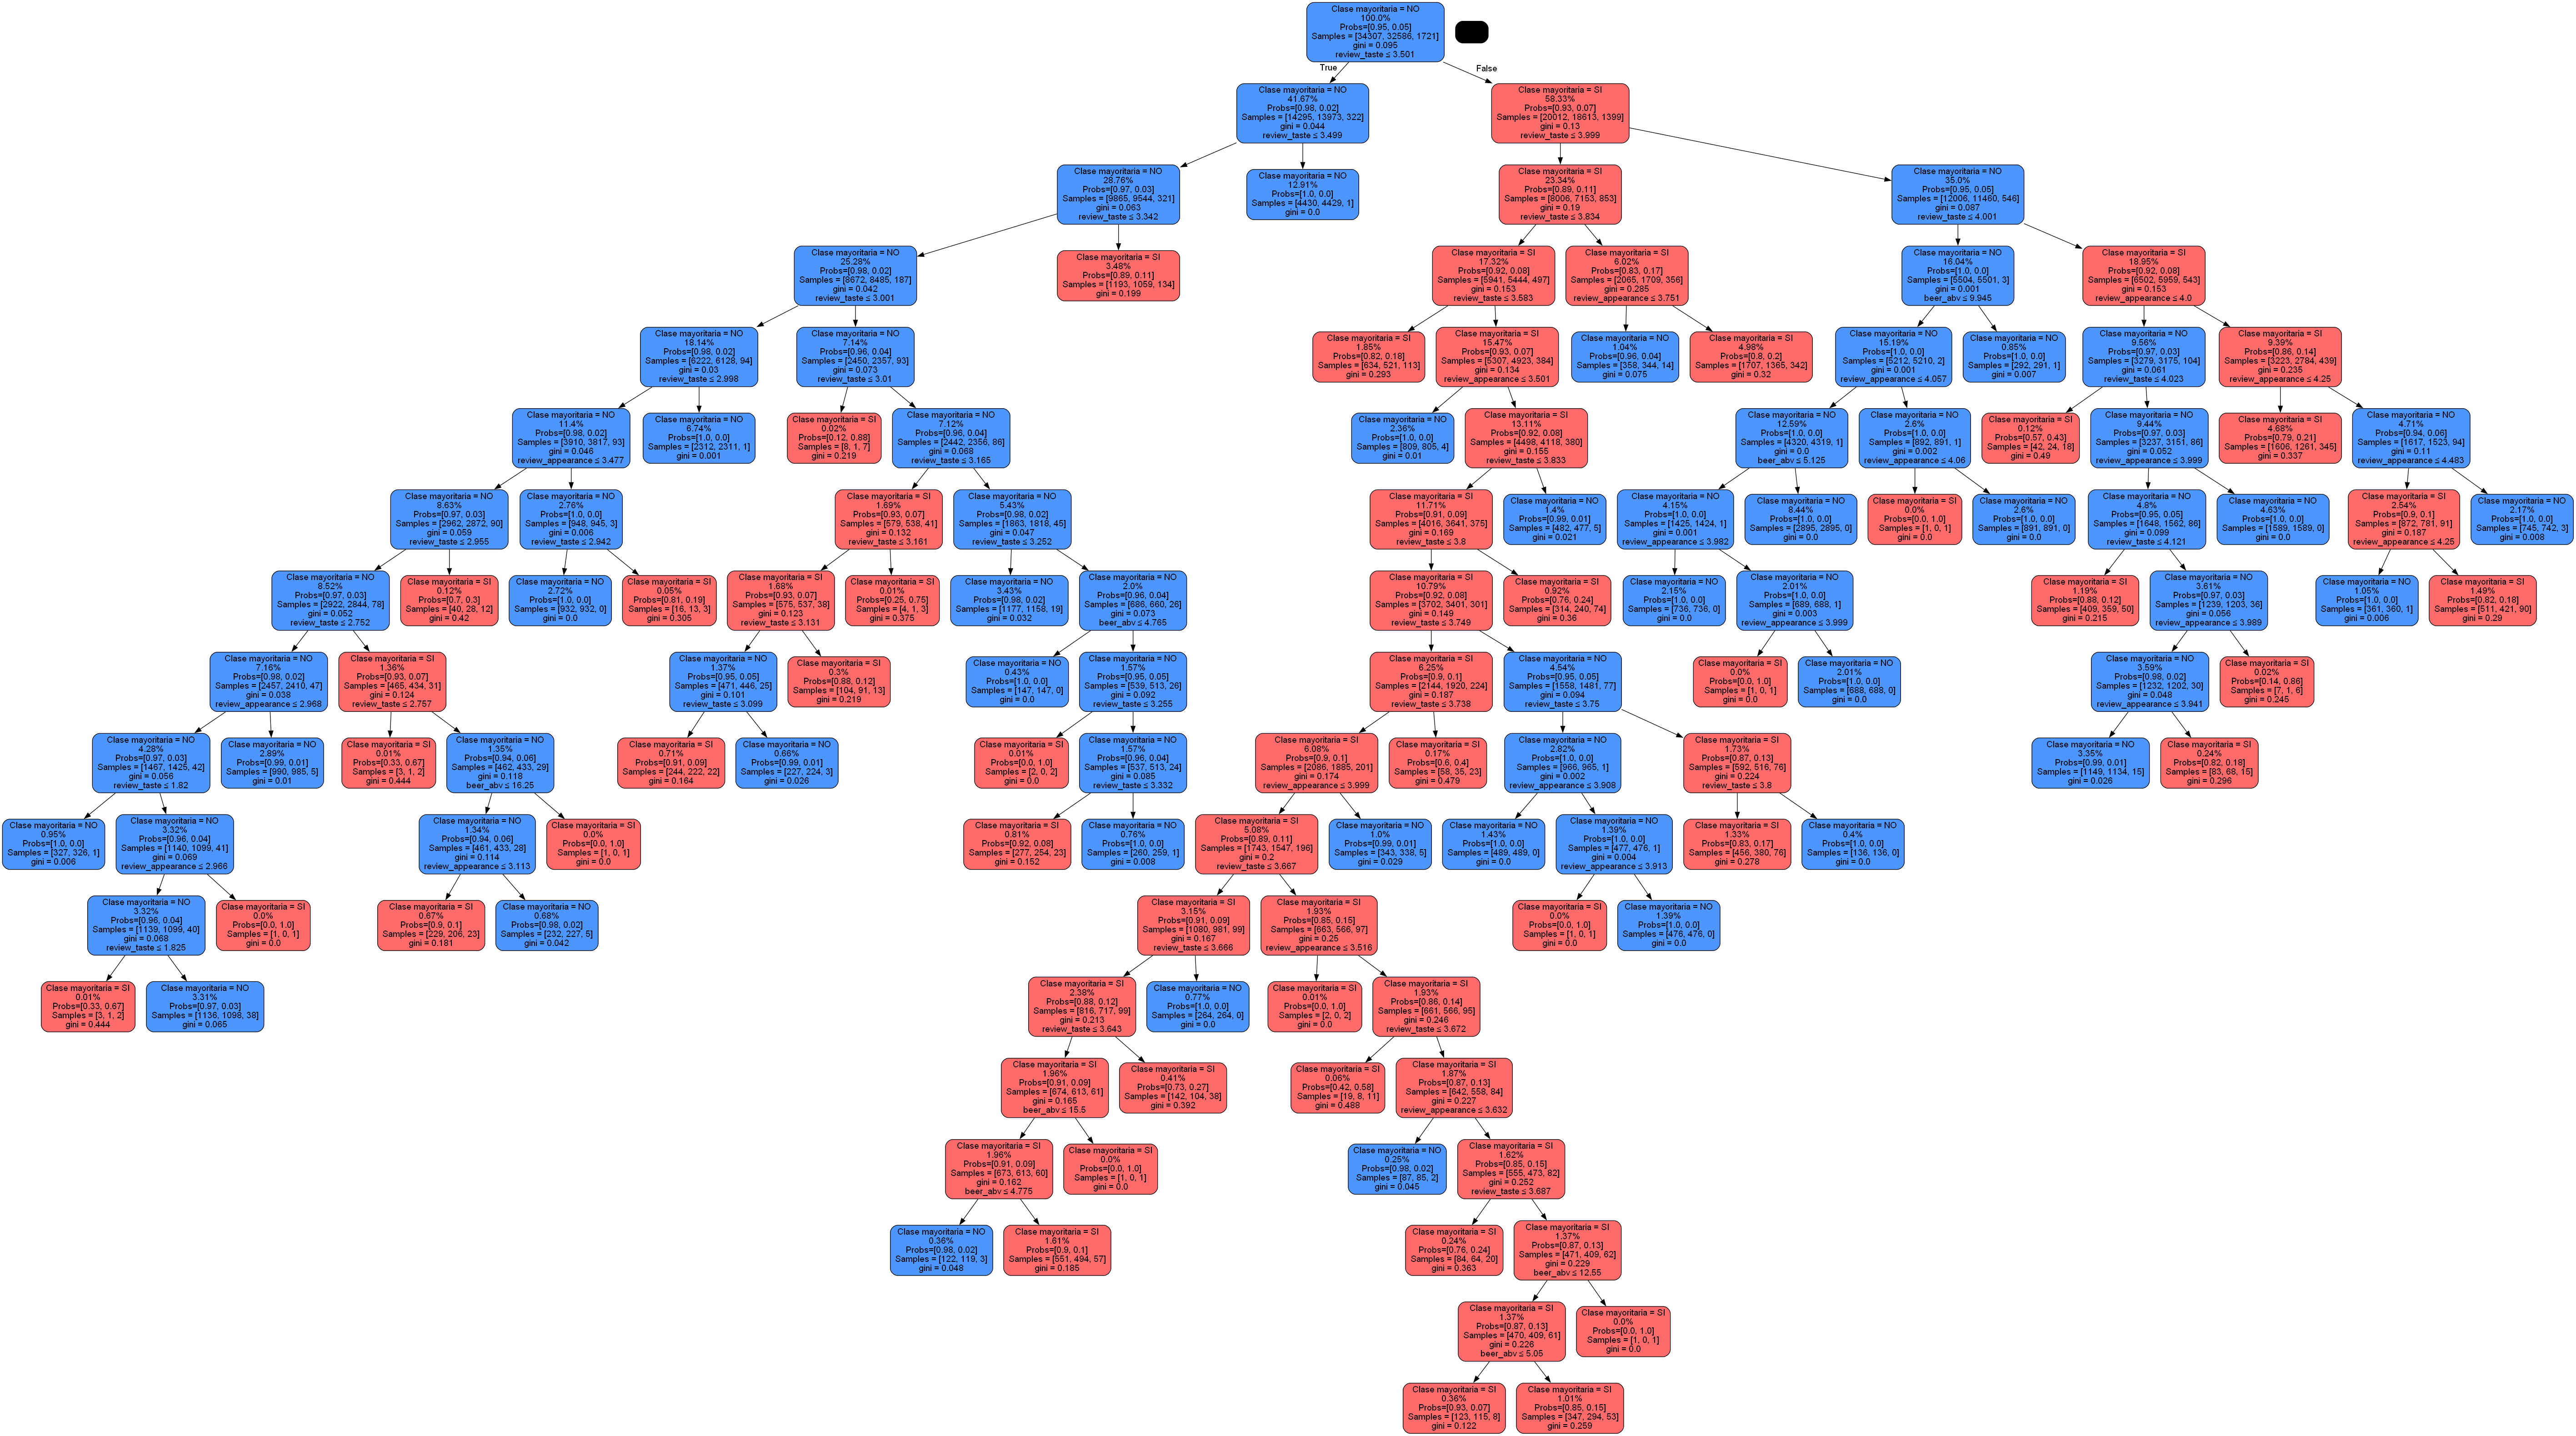

In [8]:
atu.prune_index(clf.tree_, 0, umbral_de_corte)

dot_data_value = agt.crear_arbol(clf, negative_class = 'NO', positive_class = 'SI', umbral = umbral_de_corte)

graph = pydotplus.graph_from_dot_data(dot_data_value)  
graph.set_size('"75,75"')
Image(graph.create_png())

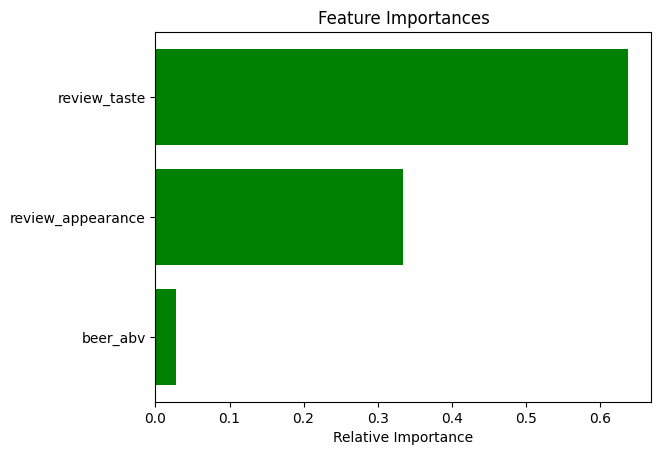

In [9]:
importances = clf.feature_importances_
indices = np.argsort(importances)
features = atributos
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Usamos SHAP values para explicar la importancia

In [10]:
import shap

C:\Users\arouiller\AppData\Local\miniconda3\envs\python_3_9_beer_analysis\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
C:\Users\arouiller\AppData\Local\miniconda3\envs\python_3_9_beer_analysis\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back

In [11]:
umbral_de_corte

0.9347742929485793

In [12]:
y_testing_pred = clf.predict_proba(X_testing)
df_y_testing_pred_proba = pd.DataFrame(y_testing_pred, columns = ['NO_prob', 'SI_prob'])
y_testing_pred = atu.evaluar_corte(df_y_testing_pred_proba['NO_prob'].values, umbral_de_corte, 'SI', 'NO')

In [13]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_testing)

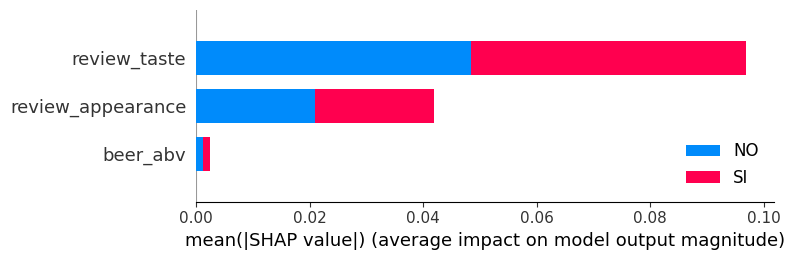

In [14]:
#Aportes a la clase NO
shap.summary_plot(shap_values, X_testing.values, feature_names = atributos, class_names= ['NO','SI'])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


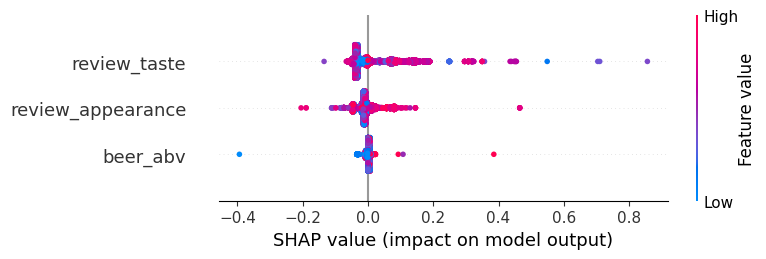

In [15]:
shap.summary_plot(shap_values[1], X_testing.values, feature_names = atributos)

In [16]:
shap_df = pd.DataFrame(data = shap_values[1])
shap_df.columns = ['shap_' + sub for sub in atributos]
shap_df = pd.concat([shap_df, X_testing, df_y_testing_pred_proba, Y_testing], axis=1)
shap_df['es_popular_prediccion'] = y_testing_pred
shap_df

,shap_beer_abv,shap_review_appearance,shap_review_taste,beer_abv,review_appearance,review_taste,NO_prob,SI_prob,es_popular,es_popular_prediccion
0,-0.001123,-0.013173,-0.035642,3.9,3.250000,3.500000,0.999774,0.000226,NO,NO
1,0.000252,0.079906,0.084496,6.2,4.166667,4.233333,0.785181,0.214819,NO,SI
2,0.000252,-0.009851,-0.040133,8.2,4.000000,3.000000,0.999567,0.000433,NO,NO
3,0.000283,-0.010005,-0.040217,5.1,4.500000,3.500000,0.999774,0.000226,NO,NO
4,0.000391,-0.007924,-0.042631,5.3,3.750000,3.750000,1.000000,0.000000,NO,NO
...,...,...,...,...,...,...,...,...,...,...
14699,0.000132,-0.009975,-0.040322,7.6,4.000000,4.000000,1.000000,0.000000,NO,NO
14700,-0.000141,-0.009984,-0.040040,5.0,4.000000,4.000000,1.000000,0.000000,NO,NO
14701,0.000252,-0.047340,-0.003077,6.6,4.000000,4.500000,1.000000,0.000000,NO,NO
14702,-0.000124,-0.018734,-0.026256,5.0,3.000000,2.500000,0.994949,0.005051,NO,NO


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


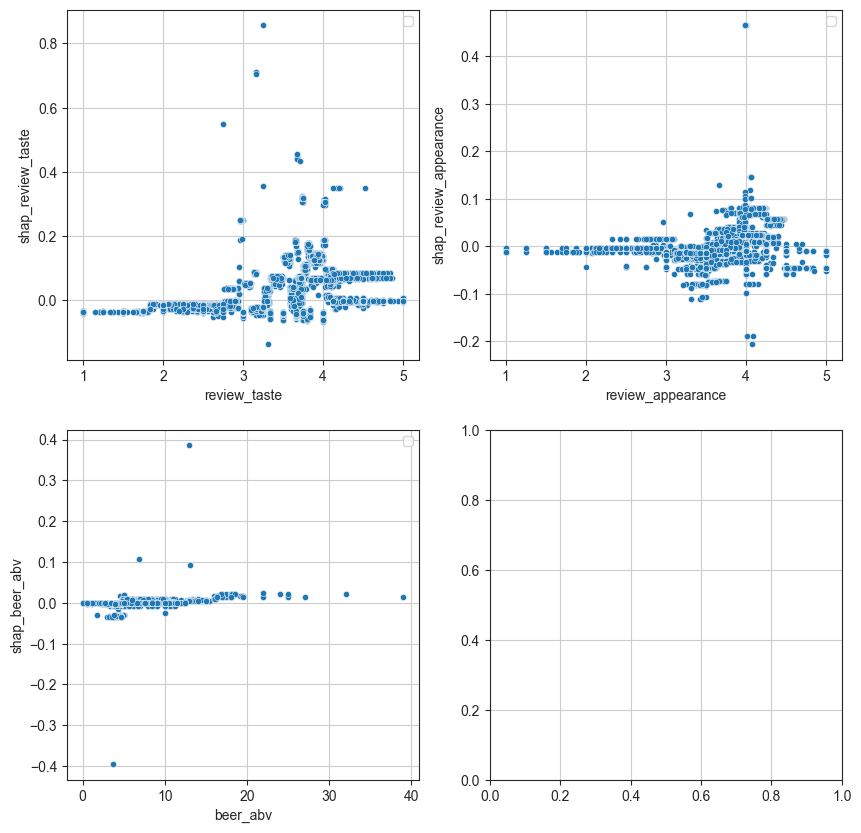

In [19]:
sns.set_style("ticks",{'axes.grid' : True})
fig, ([[ax1, ax2], [ax3, ax4]]) = plt.subplots(2, 2, figsize=(10, 10))

atributos = [
    'beer_abv', 
    #'review_aroma', 
    'review_appearance', 
    'review_taste', 
    #'review_overall', 
    #'review_palate'
]

field = 'review_taste'
g1 = sns.scatterplot(data=shap_df, x=field, y='shap_'+field, s=20, ax=ax1)
g1.legend(fontsize=9)

field = 'review_appearance'
g2 = sns.scatterplot(data=shap_df, x=field, y='shap_'+field, s=20, ax=ax2)
g2.legend(fontsize=9)


field = 'beer_abv'
g3 = sns.scatterplot(data=shap_df, x=field, y='shap_'+field, s=20, ax=ax3)
g3.legend(fontsize=9)


plt.show()

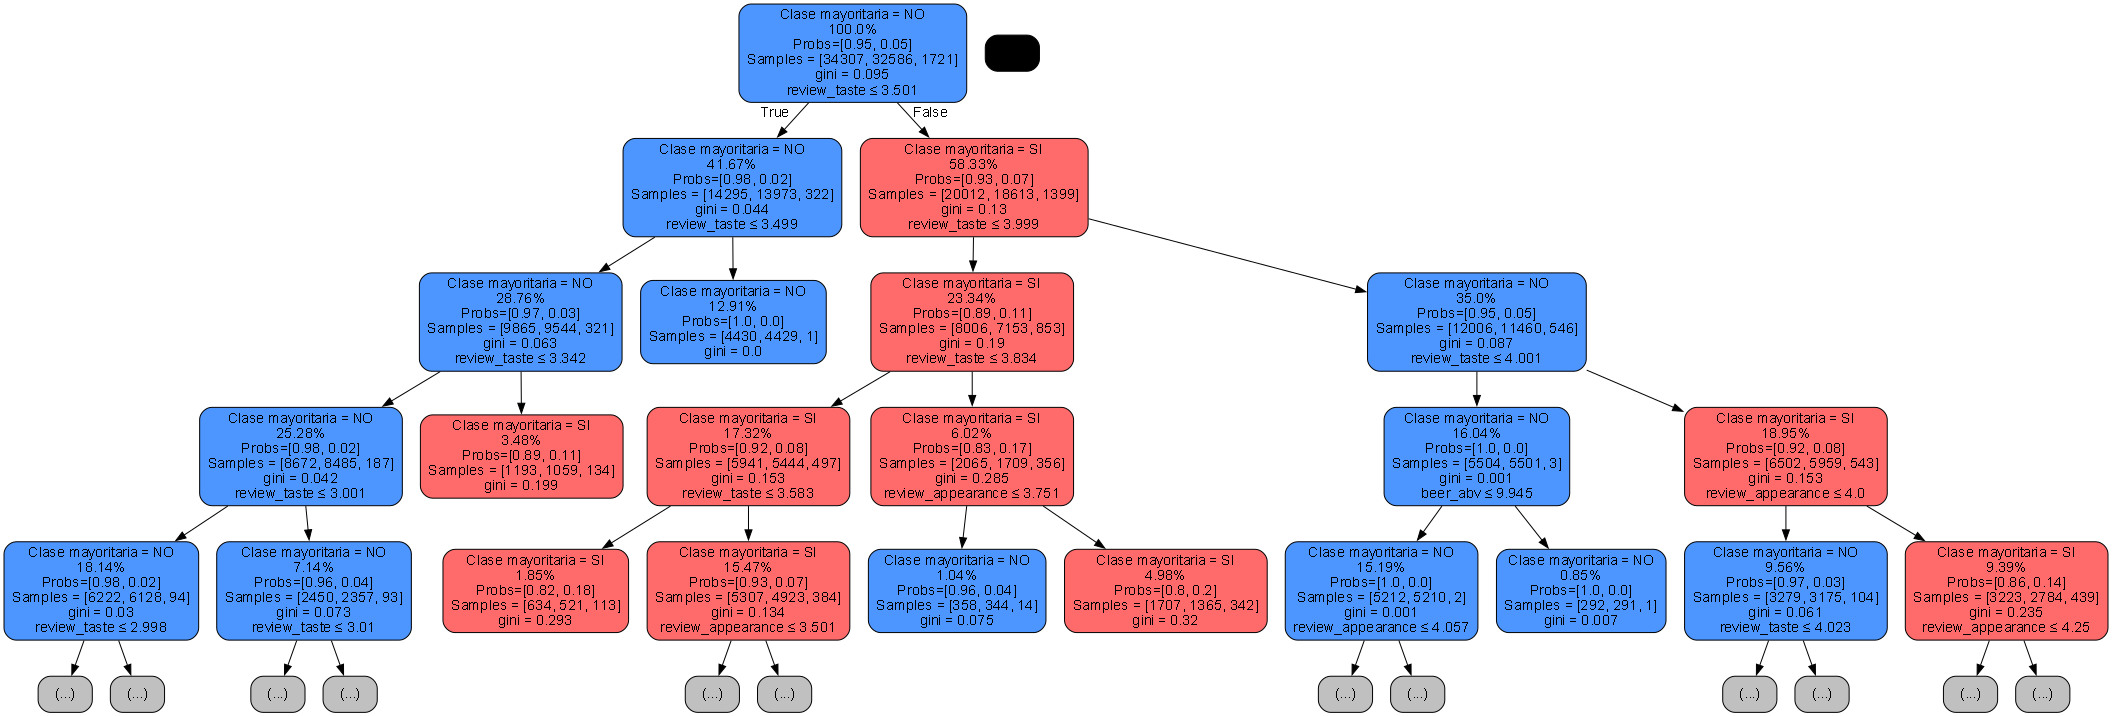

In [21]:
atu.prune_index(clf.tree_, 0, umbral_de_corte)

dot_data_value = agt.crear_arbol(clf, negative_class = 'NO', positive_class = 'SI', umbral = umbral_de_corte, max_depth=4)

graph = pydotplus.graph_from_dot_data(dot_data_value)  
graph.set_size('"22,22"')
Image(graph.create_png())

In [46]:
tmp = df_info[
    (df_info['review_taste'] >= 3)
    & (df_info['review_taste'] <=4)
].groupby(by=['es_popular']).size().reset_index(name='counts')

aux = sum(tmp.counts)

tmp['%'] = round(tmp['counts']/aux*100, 2)

tmp

,es_popular,counts,%
0,NO,22810,95.46
1,SI,1085,4.54


In [47]:
tmp = df_info[
    (df_info['review_taste'] >= 3)
    & (df_info['review_taste'] <=4)
    & (df_info['review_appearance'] >= 3.5)
    & (df_info['review_appearance'] <=4.5)
].groupby(by=['es_popular']).size().reset_index(name='counts')

aux = sum(tmp.counts)

tmp['%'] = round(tmp['counts']/aux*100, 2)

tmp

,es_popular,counts,%
0,NO,18537,95.03
1,SI,970,4.97


In [48]:
tmp = df_info[
    (df_info['review_taste'] >= 3)
    & (df_info['review_taste'] <=4)
    & (df_info['review_appearance'] >= 3.5)
    & (df_info['review_appearance'] <=4.5)
    & (df_info['beer_abv'] >= 10)
].groupby(by=['es_popular']).size().reset_index(name='counts')

aux = sum(tmp.counts)

tmp['%'] = round(tmp['counts']/aux*100, 2)

tmp

,es_popular,counts,%
0,NO,881,92.15
1,SI,75,7.85


### Casos de cervezas NO populares

##############################################################################
beer_beerid                             51203
beer_name                     Titan Irish Red
brewery_id                                211
brewery_name           Watch City Brewing Co.
beer_style                      Irish Red Ale
beer_abv                                  6.0
review_overall                            3.0
review_aroma                              3.0
review_appearance                         4.0
review_palate                             4.0
review_taste                              3.5
cantidad_revisiones                         1
revision_primera                   2009-07-16
revision_ultima                    2009-07-16
es_popular                                 NO
Name: 8232, dtype: object
##############################################################################
shap_beer_abv            -0.001117
shap_review_appearance   -0.022233
shap_review_taste        -0.026815
beer_abv             

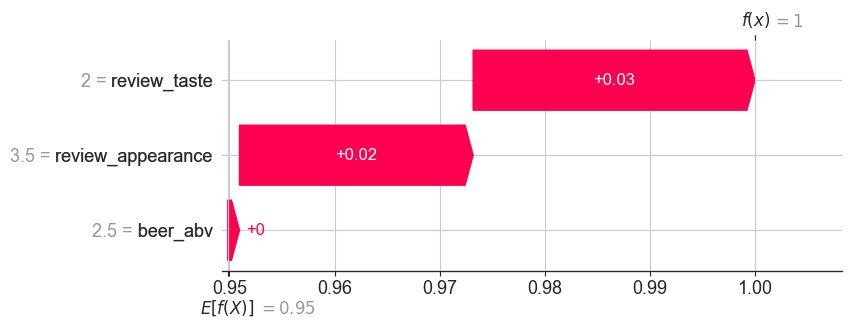

##############################################################################


##############################################################################
beer_beerid                               66735
beer_name                              Hop Solo
brewery_id                                22610
brewery_name              Mother Earth Brew Co.
beer_style             American Amber / Red Ale
beer_abv                                    4.5
review_overall                              3.0
review_aroma                                3.0
review_appearance                           3.5
review_palate                               3.0
review_taste                                3.0
cantidad_revisiones                           1
revision_primera                     2011-02-27
revision_ultima                      2011-02-27
es_popular                                   NO
Name: 11129, dtype: object
##############################################################################
shap_beer_abv 

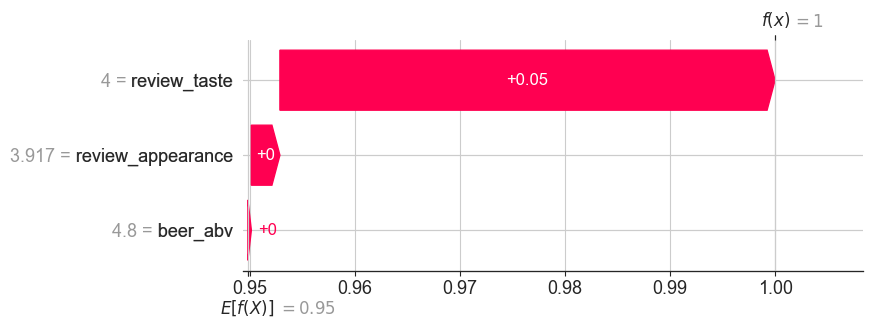

##############################################################################


##############################################################################
beer_beerid                             73741
beer_name                          Galaxy IPA
brewery_id                                642
brewery_name           Free State Brewing Co.
beer_style                       American IPA
beer_abv                                  7.6
review_overall                           4.25
review_aroma                            4.125
review_appearance                         4.0
review_palate                             4.0
review_taste                              4.5
cantidad_revisiones                         4
revision_primera                   2011-10-03
revision_ultima                    2011-11-18
es_popular                                 NO
Name: 13097, dtype: object
##############################################################################
shap_beer_abv             0.000252
shap_revi

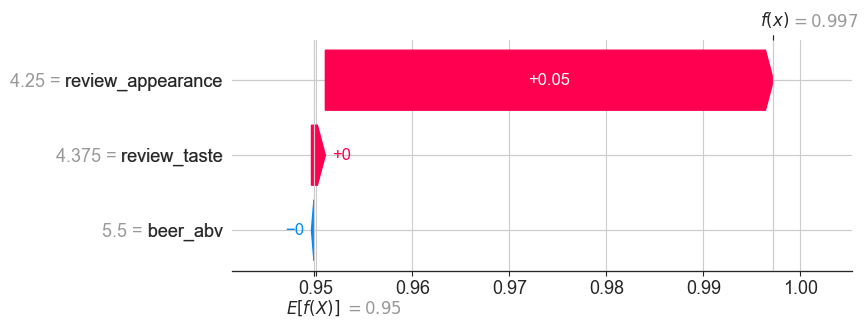

##############################################################################


##############################################################################
beer_beerid                           75683
beer_name                 Pumpkinfest Lager
brewery_id                              394
brewery_name            Stoudts Brewing Co.
beer_style             Märzen / Oktoberfest
beer_abv                                4.5
review_overall                         3.75
review_aroma                           3.25
review_appearance                      3.75
review_palate                           3.5
review_taste                           3.75
cantidad_revisiones                       2
revision_primera                 2011-11-25
revision_ultima                  2011-12-14
es_popular                               NO
Name: 7767, dtype: object
##############################################################################
shap_beer_abv             0.000132
shap_review_appearance   -0.014273
shap_

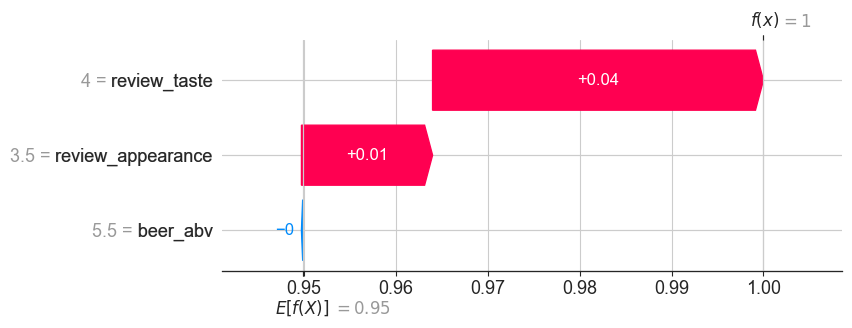

##############################################################################


##############################################################################
beer_beerid                                    13480
beer_name                                 Amoeba Ale
brewery_id                                      2042
brewery_name           Santa Barbara Brewing Company
beer_style                          Belgian Pale Ale
beer_abv                                         5.0
review_overall                                   3.5
review_aroma                                     4.0
review_appearance                                4.0
review_palate                                    4.0
review_taste                                     3.5
cantidad_revisiones                                1
revision_primera                          2003-10-13
revision_ultima                           2003-10-13
es_popular                                        NO
Name: 6295, dtype: object
###################

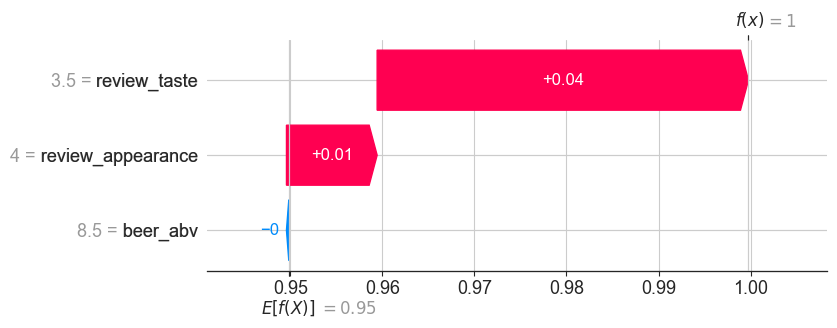

##############################################################################


##############################################################################
beer_beerid                               25327
beer_name                      Raging Rhino Red
brewery_id                                 5115
brewery_name              Steelhead Brewing Co.
beer_style             American Amber / Red Ale
beer_abv                                    5.4
review_overall                         3.166667
review_aroma                           3.166667
review_appearance                      3.333333
review_palate                          3.166667
review_taste                           3.166667
cantidad_revisiones                           3
revision_primera                     2007-02-12
revision_ultima                      2010-12-25
es_popular                                   NO
Name: 11125, dtype: object
##############################################################################
shap_beer_abv 

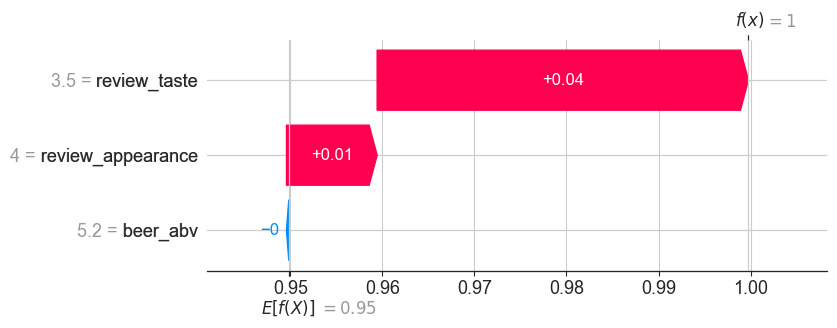

##############################################################################


##############################################################################
beer_beerid                                17088
beer_name                         Easter Bunnies
brewery_id                                  9417
brewery_name           Itchen Valley Brewery Ltd
beer_style                        English Bitter
beer_abv                                     3.9
review_overall                              4.25
review_aroma                                 4.0
review_appearance                            4.0
review_palate                                4.0
review_taste                                 4.0
cantidad_revisiones                            2
revision_primera                      2004-04-12
revision_ultima                       2006-04-14
es_popular                                    NO
Name: 9788, dtype: object
##############################################################################


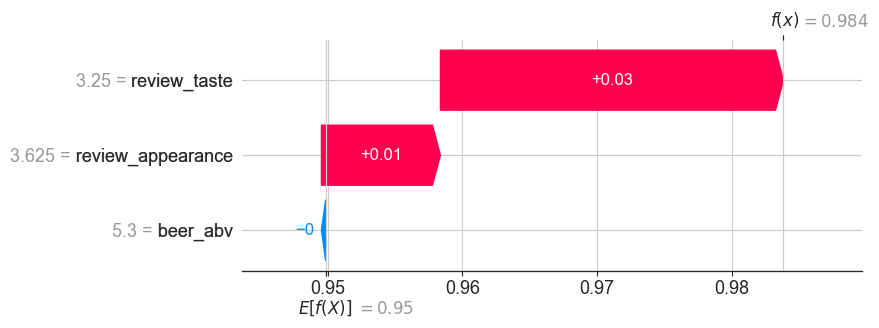

##############################################################################


##############################################################################
beer_beerid                                       56234
beer_name                  Light Horse Belgian Pale Ale
brewery_id                                         9792
brewery_name           Natty Greene's Pub & Brewing Co.
beer_style                             Belgian Pale Ale
beer_abv                                            4.8
review_overall                                      3.5
review_aroma                                   3.166667
review_appearance                              3.833333
review_palate                                  3.666667
review_taste                                        3.5
cantidad_revisiones                                   3
revision_primera                             2010-02-20
revision_ultima                              2010-10-28
es_popular                                           NO


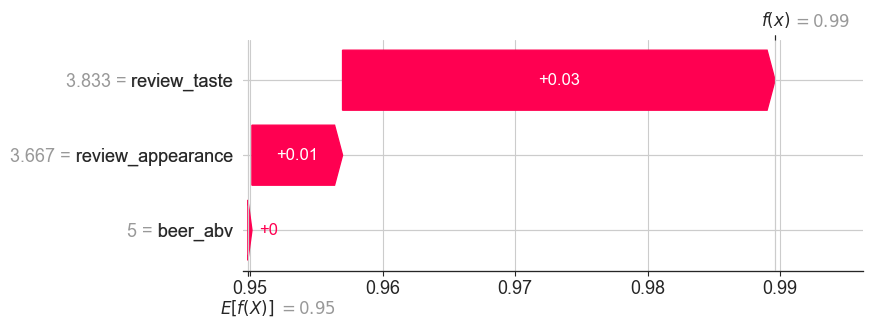

##############################################################################


##############################################################################
beer_beerid                               26700
beer_name              Augusta Bräu Schwarzbier
brewery_id                                 5711
brewery_name                       Augusta Bräu
beer_style                          Schwarzbier
beer_abv                                    5.0
review_overall                              3.0
review_aroma                                2.5
review_appearance                           2.5
review_palate                               3.0
review_taste                                3.0
cantidad_revisiones                           1
revision_primera                     2005-11-01
revision_ultima                      2005-11-01
es_popular                                   NO
Name: 12186, dtype: object
##############################################################################
shap_beer_abv 

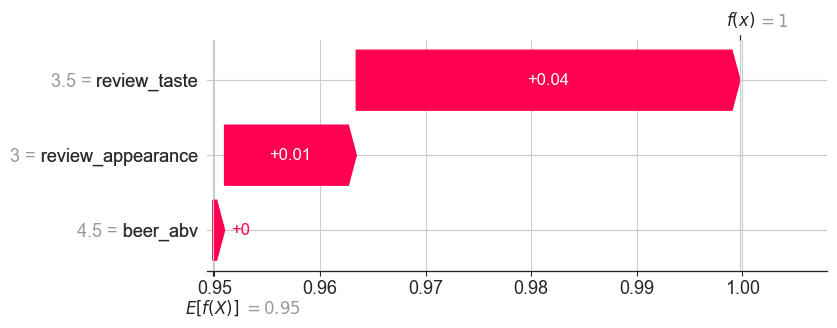

##############################################################################


##############################################################################
beer_beerid                                   48176
beer_name                                 PJ Harvey
brewery_id                                    12097
brewery_name                      BrewPub København
beer_style             English India Pale Ale (IPA)
beer_abv                                        6.8
review_overall                                  3.5
review_aroma                                    4.5
review_appearance                               4.0
review_palate                                   4.0
review_taste                                    3.5
cantidad_revisiones                               1
revision_primera                         2009-02-27
revision_ultima                          2009-02-27
es_popular                                       NO
Name: 5413, dtype: object
##################################

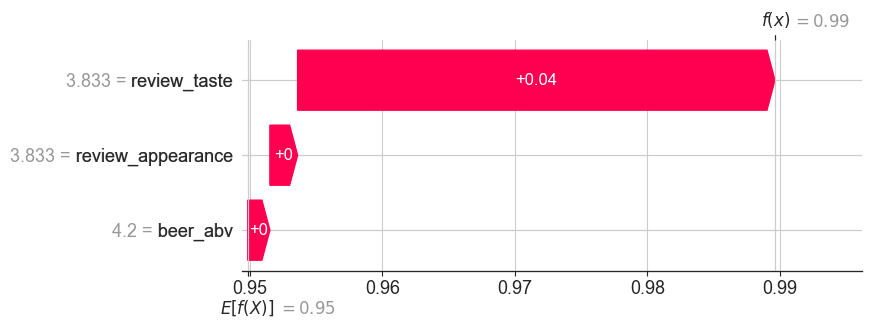

##############################################################################




In [32]:
rows = shap_df[
    (shap_df['es_popular'] == 'NO')
     &(shap_df['es_popular_prediccion'] == 'NO')
].sample(10).index

for row in rows:
    print('##############################################################################')
    print(df_info.iloc[row])
    print('##############################################################################')
    print(shap_df.iloc[row])
    explanation = shap.Explanation(
            values=shap_values[0][row], 
            base_values=explainer.expected_value[0], 
            data=X_testing.iloc[row],
            feature_names=atributos
    )

    shap.waterfall_plot(explanation)
    print('##############################################################################\n\n')

### Casos de cervezas populares

##############################################################################
beer_beerid                          48664
beer_name              Bootleg Light Lager
brewery_id                            2553
brewery_name               Bootleg Brewery
beer_style             American Pale Lager
beer_abv                               3.4
review_overall                         4.5
review_aroma                           3.0
review_appearance                      3.5
review_palate                          3.0
review_taste                           3.5
cantidad_revisiones                      1
revision_primera                2009-03-23
revision_ultima                 2009-03-23
es_popular                              NO
Name: 13059, dtype: object
##############################################################################
shap_beer_abv            -0.001123
shap_review_appearance   -0.013173
shap_review_taste         0.076454
beer_abv                       4.7
review_appearance         3.42

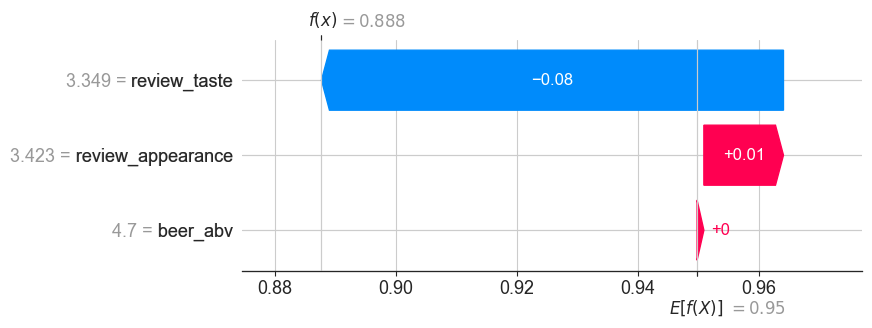

##############################################################################


##############################################################################
beer_beerid                             74902
beer_name                          Tundra Ice
brewery_id                                435
brewery_name             Minhas Craft Brewery
beer_style             American Adjunct Lager
beer_abv                                  6.2
review_overall                           2.25
review_aroma                              2.0
review_appearance                        2.25
review_palate                             2.5
review_taste                             2.75
cantidad_revisiones                         2
revision_primera                   2011-11-05
revision_ultima                    2011-12-18
es_popular                                 NO
Name: 7605, dtype: object
##############################################################################
shap_beer_abv             0.000516
shap_revie

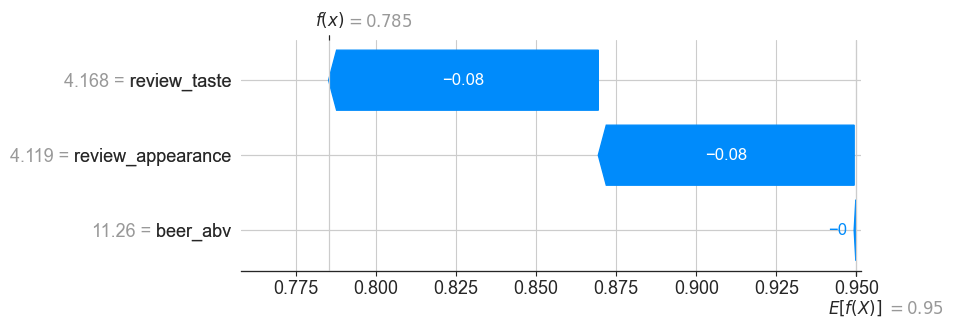

##############################################################################


##############################################################################
beer_beerid                               59713
beer_name                             Alpha Dog
brewery_id                                16315
brewery_name                            BrewDog
beer_style             American Amber / Red Ale
beer_abv                                    4.5
review_overall                              4.0
review_aroma                               3.75
review_appearance                           4.0
review_palate                          3.666667
review_taste                               3.75
cantidad_revisiones                           6
revision_primera                     2010-07-01
revision_ultima                      2011-03-12
es_popular                                   NO
Name: 611, dtype: object
##############################################################################
shap_beer_abv   

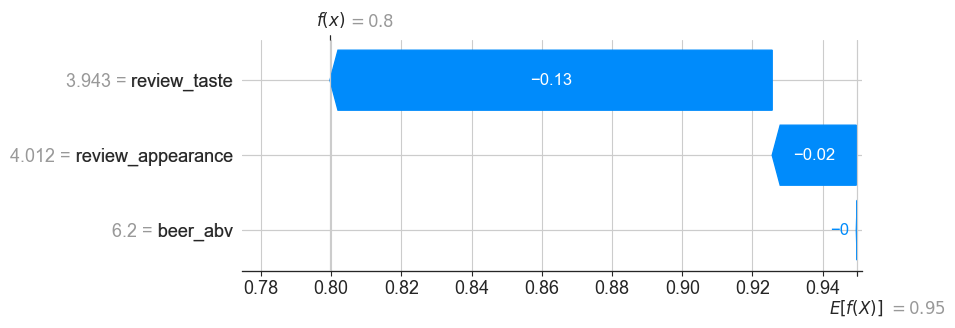

##############################################################################


##############################################################################
beer_beerid                                        48508
beer_name                                Hot Rocks Lager
brewery_id                                          5318
brewery_name           Port Brewing Company / Pizza Port
beer_style                               Euro Dark Lager
beer_abv                                             6.5
review_overall                                  3.867857
review_aroma                                    3.678571
review_appearance                               3.839286
review_palate                                   3.817857
review_taste                                    3.839286
cantidad_revisiones                                  140
revision_primera                              2009-03-17
revision_ultima                               2011-12-24
es_popular                                

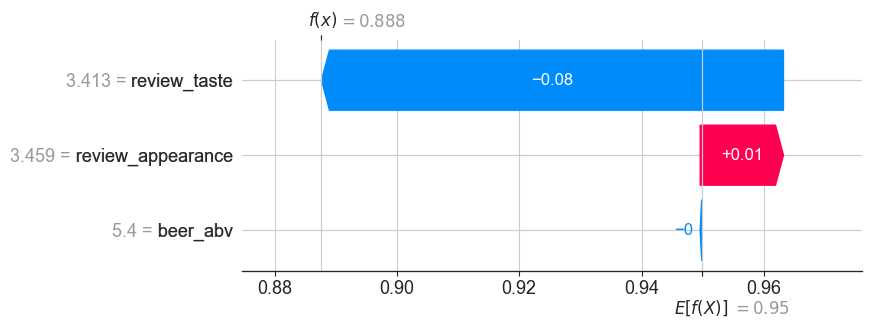

##############################################################################


##############################################################################
beer_beerid                              51510
beer_name               Buckaroo Brew Pale Ale
brewery_id                                2311
brewery_name             Ruby Mountain Brewing
beer_style             American Pale Ale (APA)
beer_abv                                   5.0
review_overall                             3.5
review_aroma                              3.25
review_appearance                          3.0
review_palate                              3.5
review_taste                              3.25
cantidad_revisiones                          2
revision_primera                    2009-07-30
revision_ultima                     2010-10-13
es_popular                                  NO
Name: 12451, dtype: object
##############################################################################
shap_beer_abv             0.0

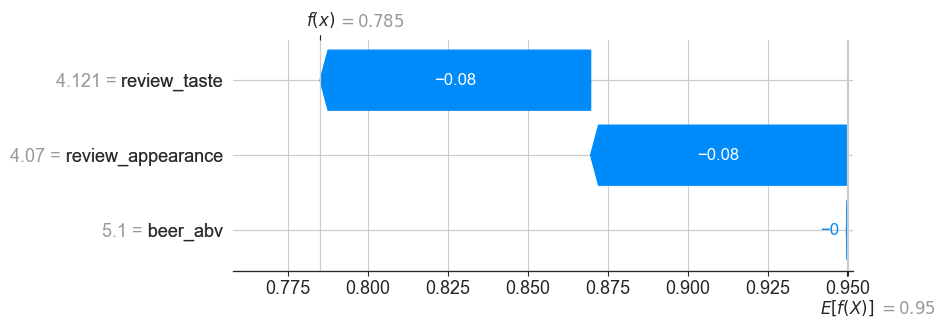

##############################################################################


##############################################################################
beer_beerid                                                   14346
beer_name                                       Aristokrat Svetloye
brewery_id                                                     7928
brewery_name           Russkaya Pivovarennaya Kompaniya "Chmelyoff"
beer_style                                          Euro Pale Lager
beer_abv                                                        4.5
review_overall                                                  2.0
review_aroma                                                    2.0
review_appearance                                               2.5
review_palate                                                   2.5
review_taste                                                    2.0
cantidad_revisiones                                               1
revision_primera        

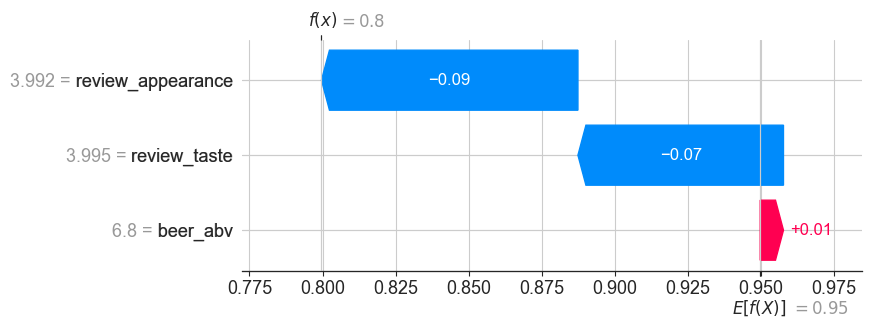

##############################################################################


##############################################################################
beer_beerid                                           45984
beer_name              Dunedin Barrel Aged Spatz BarkeyWine
brewery_id                                             1620
brewery_name                                Dunedin Brewery
beer_style                              American Barleywine
beer_abv                                                9.0
review_overall                                          4.0
review_aroma                                            4.0
review_appearance                                       4.0
review_palate                                           4.0
review_taste                                            4.5
cantidad_revisiones                                       1
revision_primera                                 2008-11-17
revision_ultima                                  2008-11-17


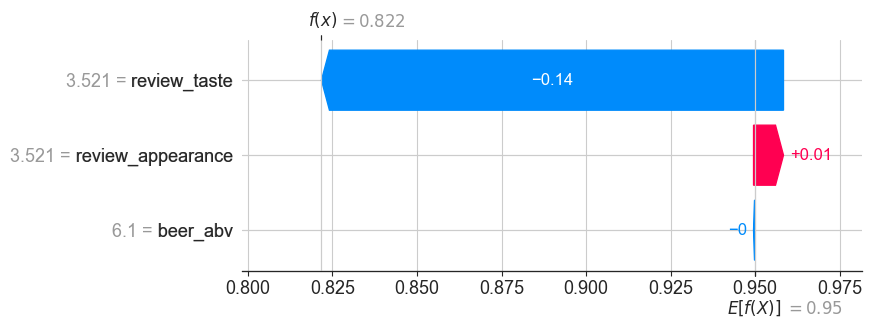

##############################################################################


##############################################################################
beer_beerid                              26943
beer_name                        Vapeur D' été
brewery_id                                 841
brewery_name                Brasserie à Vapeur
beer_style             Belgian Strong Pale Ale
beer_abv                                   7.5
review_overall                             3.5
review_aroma                               4.0
review_appearance                          3.0
review_palate                              3.5
review_taste                               3.5
cantidad_revisiones                          1
revision_primera                    2005-11-15
revision_ultima                     2005-11-15
es_popular                                  NO
Name: 10569, dtype: object
##############################################################################
shap_beer_abv            -0.0

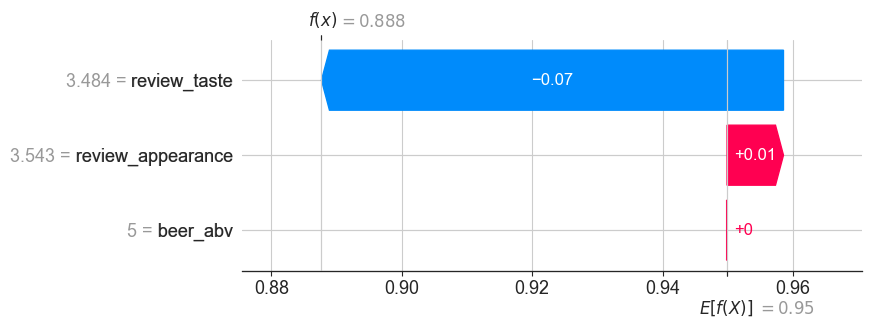

##############################################################################


##############################################################################
beer_beerid                                     56132
beer_name                                       Orion
brewery_id                                        632
brewery_name           Triple Rock Brewery & Alehouse
beer_style                        American Barleywine
beer_abv                                          9.5
review_overall                                    4.0
review_aroma                                     3.75
review_appearance                                 4.0
review_palate                                     4.0
review_taste                                      4.0
cantidad_revisiones                                 2
revision_primera                           2010-02-15
revision_ultima                            2010-06-13
es_popular                                         NO
Name: 5373, dtype: object
####

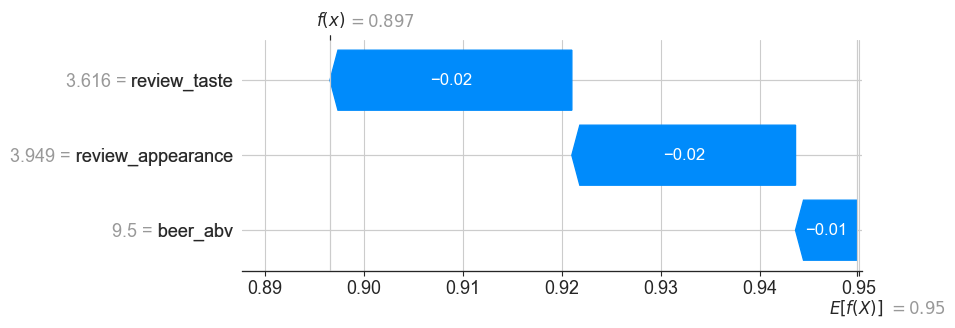

##############################################################################


##############################################################################
beer_beerid                      46274
beer_name                        Kaldi
brewery_id                       17207
brewery_name              Bruggsmiðjan
beer_style             Euro Pale Lager
beer_abv                           5.0
review_overall                     3.5
review_aroma                      3.75
review_appearance                 3.75
review_palate                      3.0
review_taste                       3.0
cantidad_revisiones                  2
revision_primera            2008-12-05
revision_ultima             2010-09-12
es_popular                          NO
Name: 8539, dtype: object
##############################################################################
shap_beer_abv             0.000391
shap_review_appearance     0.01533
shap_review_taste         0.169784
beer_abv                       9.4
review_app

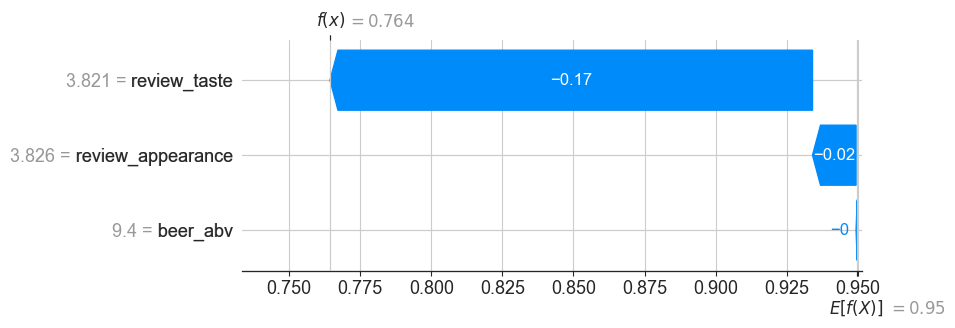

##############################################################################




In [33]:
rows = shap_df[
    (shap_df['es_popular'] == 'SI')
     &(shap_df['es_popular_prediccion'] == 'SI')
].sample(10).index

for row in rows:
    print('##############################################################################')
    print(df_info.iloc[row])
    print('##############################################################################')
    print(shap_df.iloc[row])
    explanation = shap.Explanation(
            values=shap_values[0][row], 
            base_values=explainer.expected_value[0], 
            data=X_testing.iloc[row],
            feature_names=atributos
    )

    shap.waterfall_plot(explanation)
    print('##############################################################################\n\n')